In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# We'll need to update our path to import from Drive.
import sys
sys.path.append('/content/drive/MyDrive/procesados/')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt 
import matplotlib.gridspec as gridspec
# from scipy.signal import butter, lfilter
from sklearn import decomposition

Bajo paquete para trabajar con EEG- Me permite ver la topografía

In [4]:
!pip install mne
import mne

     |████████████████████████████████| 6.9 MB 4.4 MB/s 


In [8]:
path = '/content/drive/MyDrive/procesados/'
filename = 'suj_8_bl_1.txt'

datos = pd.read_csv(path+filename, sep=',', header=None)
EEGdata = datos.to_numpy()
srate=128
ch    = EEGdata.shape[0]
samples = EEGdata.shape[1] 

print("Sampling rate: {:.2f} Hz".format(srate))
print("Data shape: {:d} samples x {:d} channels".format(EEGdata.shape[1], EEGdata.shape[0]))
print("Tiempo total : {:.2f} ".format(samples/srate))

Sampling rate: 128.00 Hz
Data shape: 7681 samples x 30 channels
Tiempo total : 60.01 


Los registros fueron tomados con el montage 10-20. Tengo que armarlo que los electrodos tengan esta distribución:
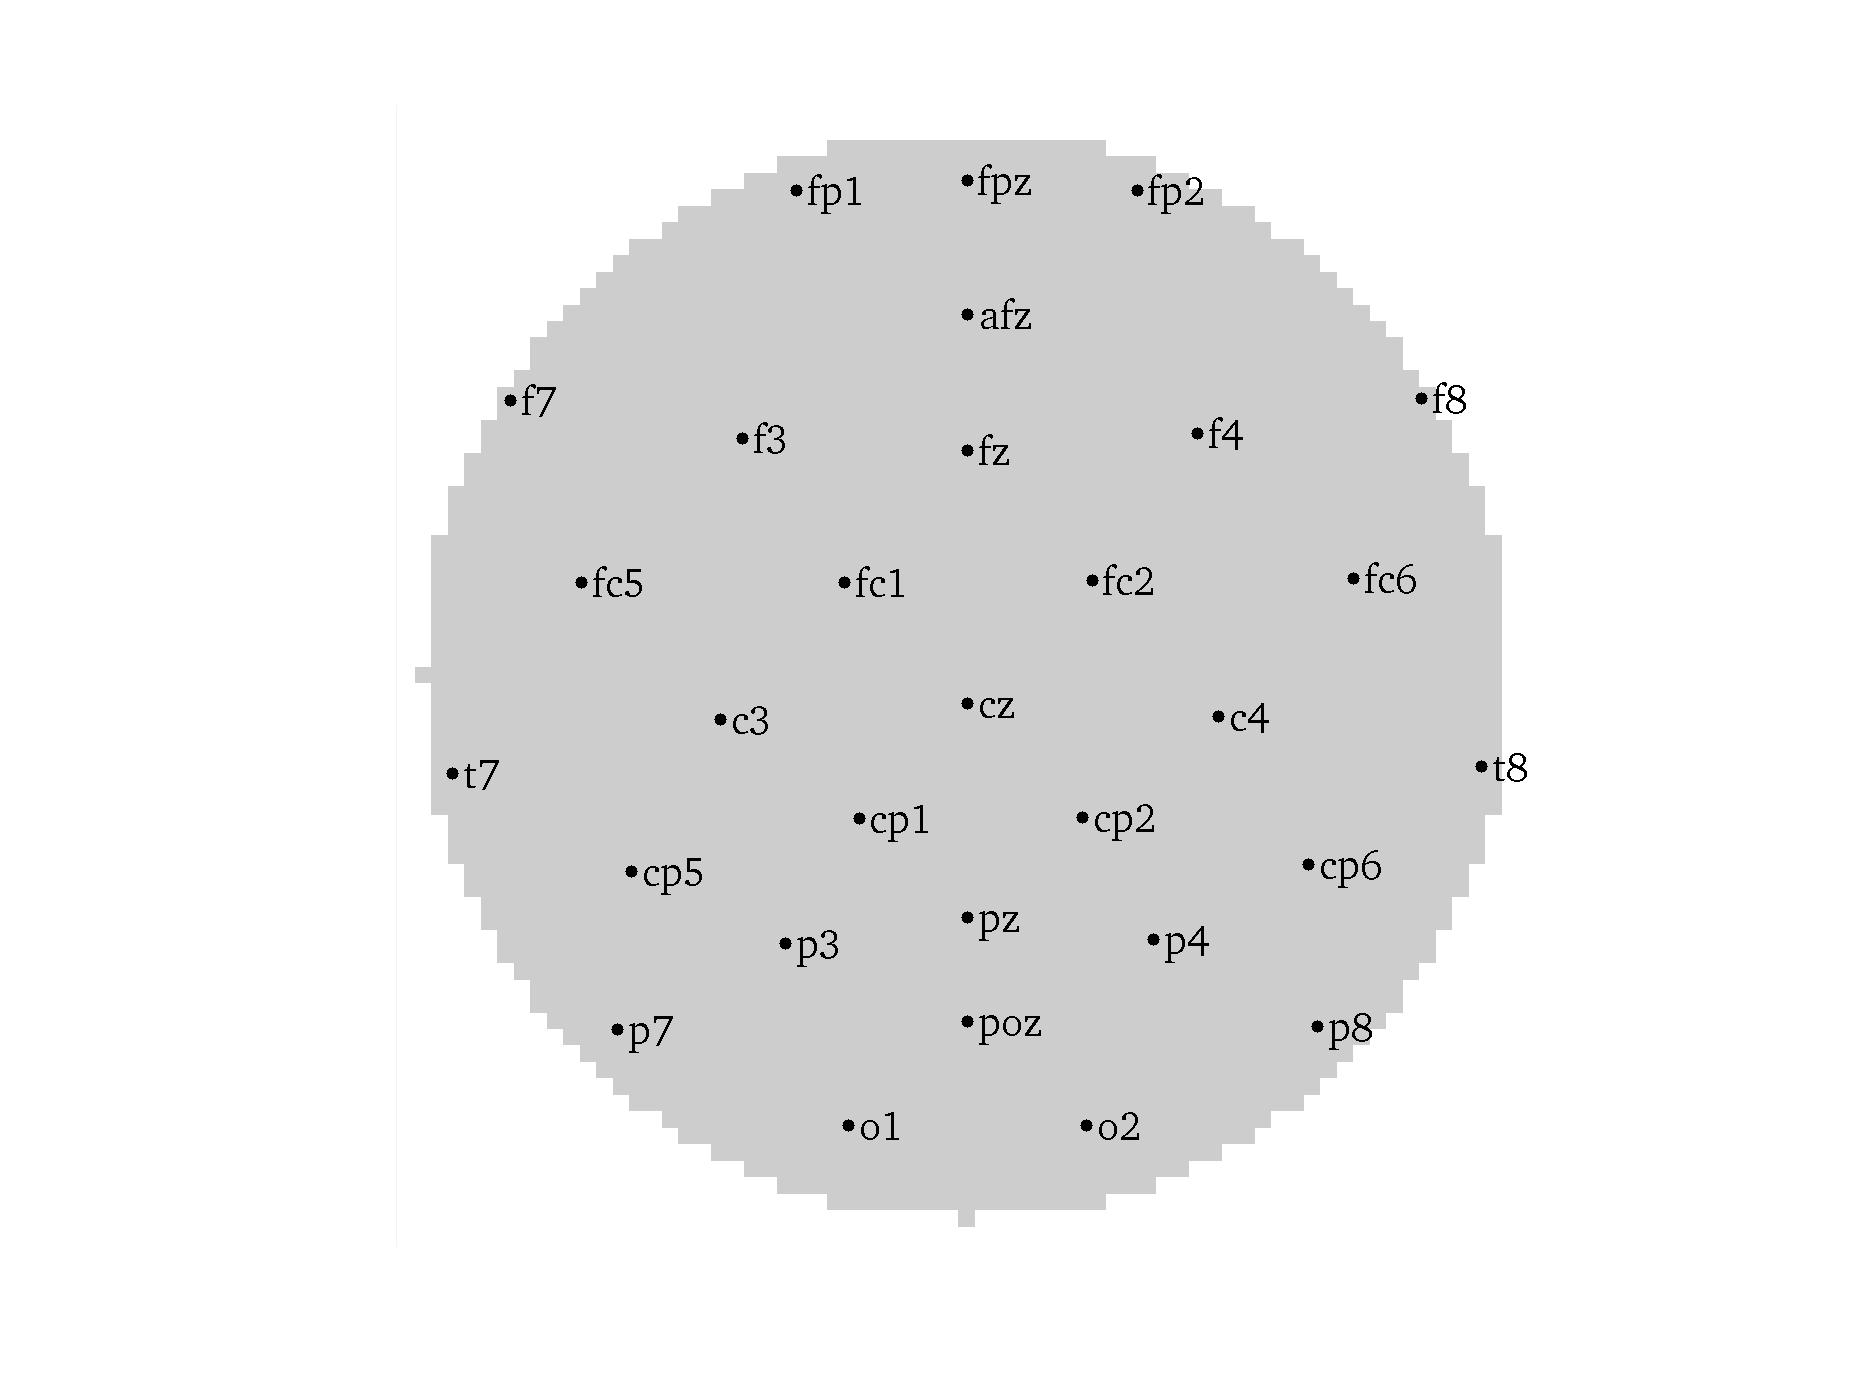

In [10]:
# De antes, creo que necesarias

# Montage 10-20
mont1020 = mne.channels.make_standard_montage('standard_1020')
# Elijo canales que tengo
kept_channels = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 
                 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz', 'FC1', 'FC2',
                 'FC5', 'FC6','CP1','CP2','CP5','CP6','AFz','Fpz','POz']

ind = [i for (i, channel) in enumerate(mont1020.ch_names) if channel in kept_channels]
mont1020_30 = mont1020.copy()
# Me quedo solo con los canales seleccionados
mont1020_30.ch_names = [mont1020.ch_names[x] for x in ind]
kept_channel_info = [mont1020.dig[x+3] for x in ind]
# Me quedo con las referencias desde dónde están ubicados los canales
mont1020_30.dig = mont1020.dig[0:3]+kept_channel_info
info_eeg = mne.create_info(ch_names=mont1020_30.ch_names, sfreq=128,
                            ch_types='eeg').set_montage(mont1020_30)

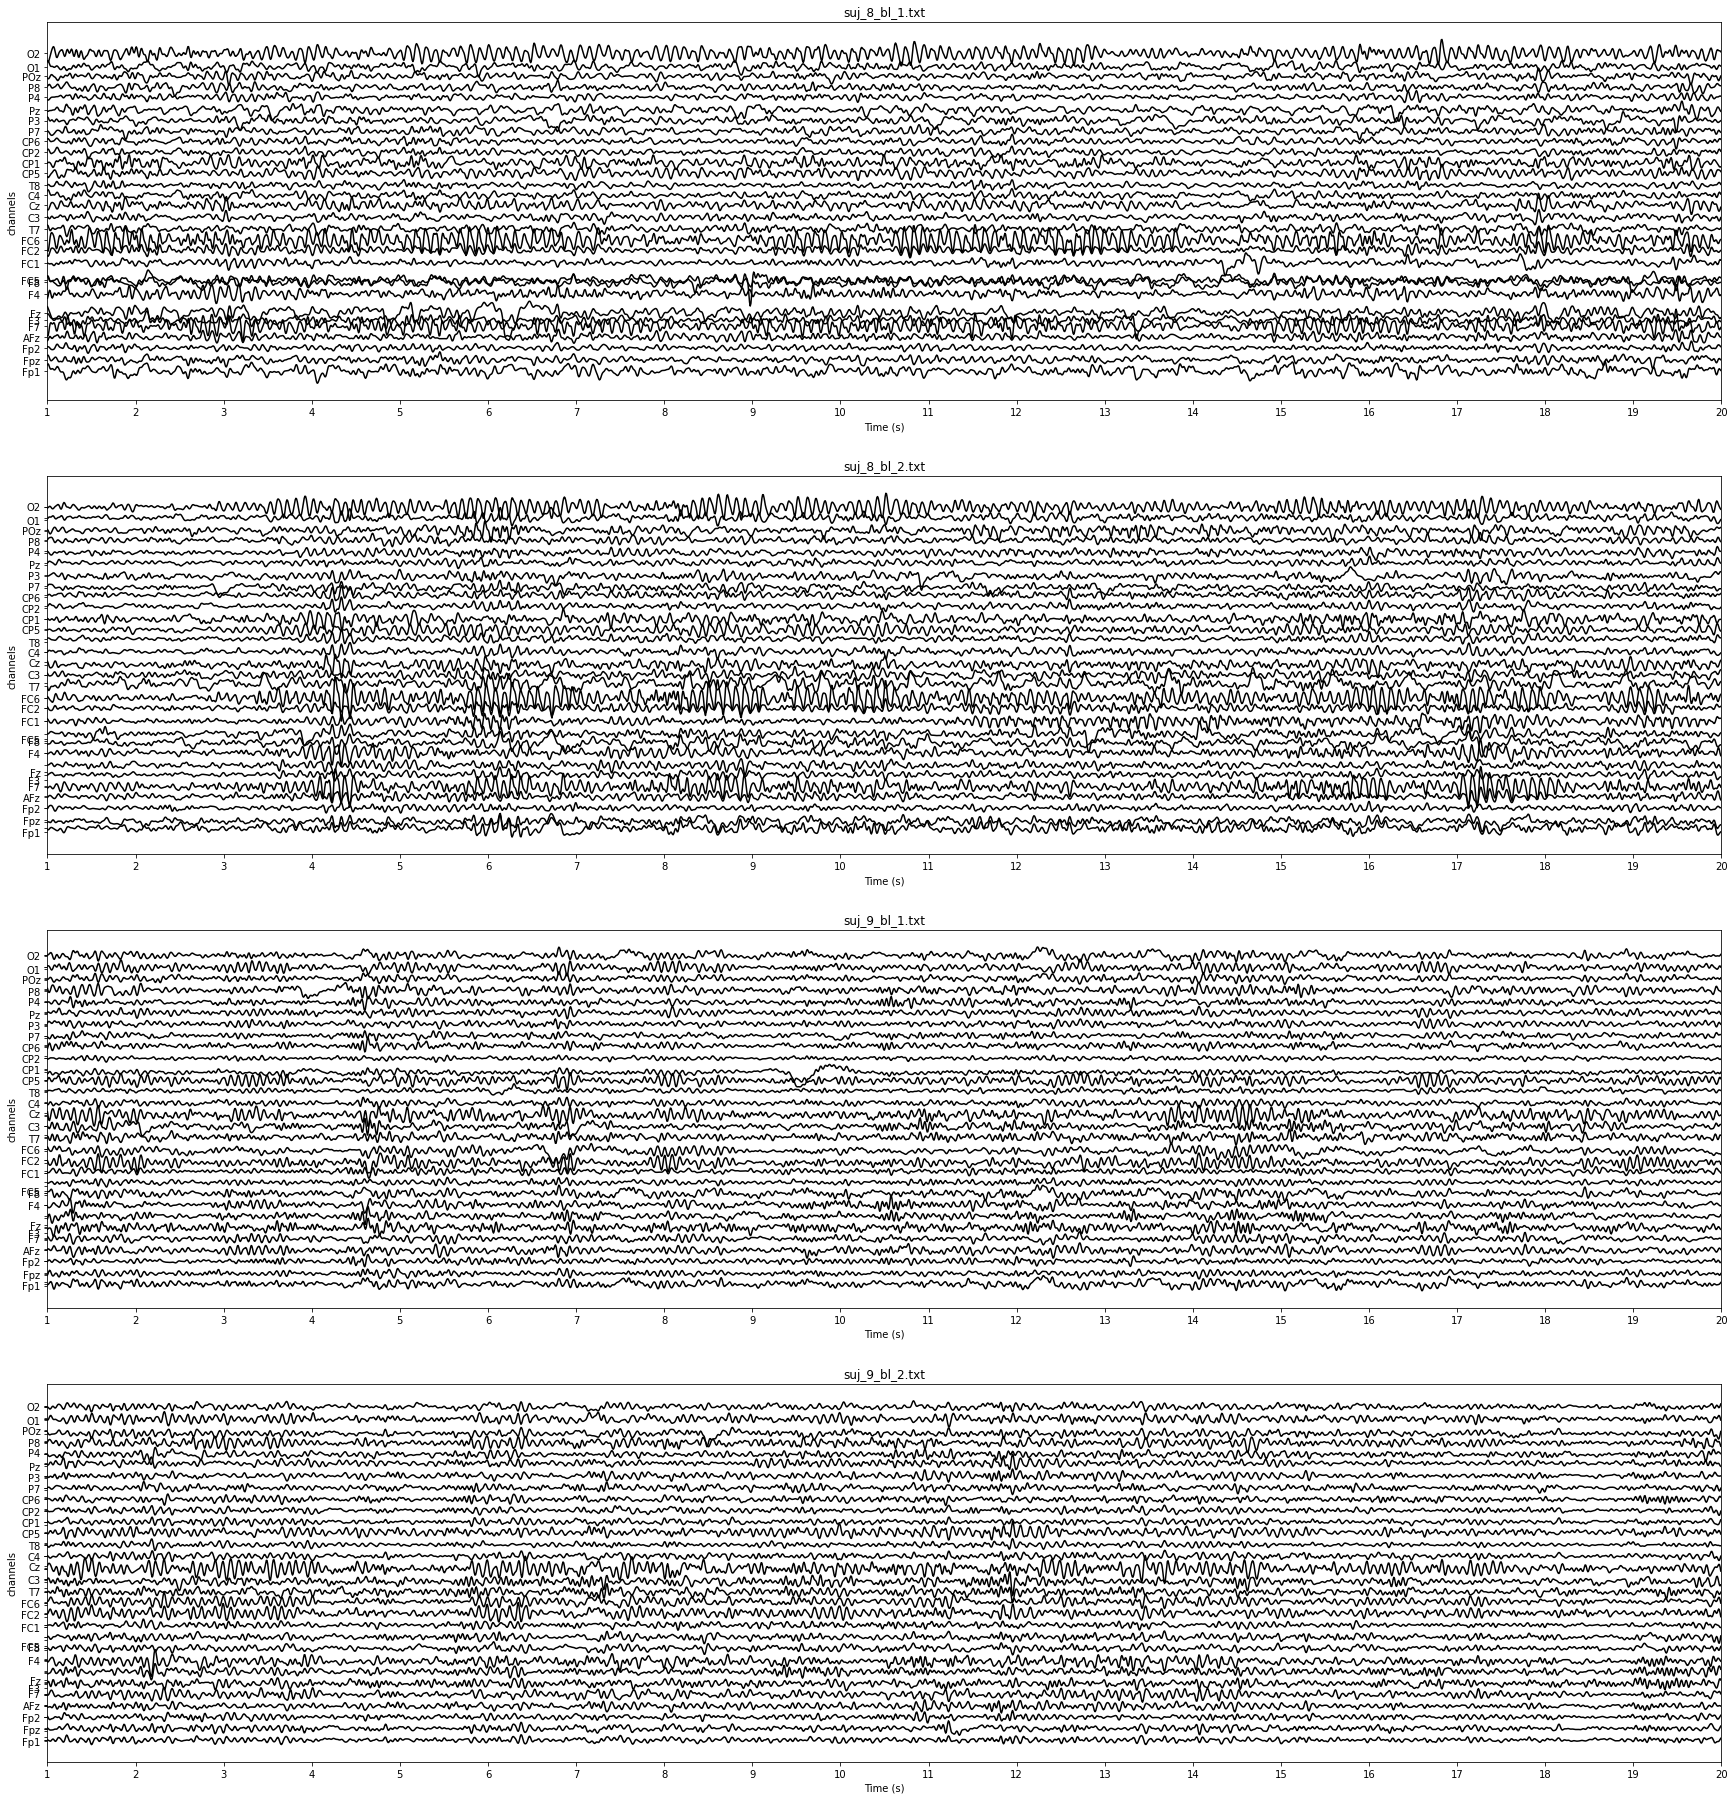

In [11]:
# Levanto y grafico los txt crudos

inicio = 1
fin    = 20
xticks = np.arange(inicio*srate,(fin+1)*srate,srate)
#fig.suptitle('Series temporales (uV)')
yticks=[]

# filename = '/suj_8_bl_1.txt'
sujetos = [8,9]#,10,12,13] # sujetos a graficar: 8,9,10,12,13
periodos = [1,2] #hay solamente dos: 1, 2

cant_graf = len(sujetos)*len(periodos)
alto_graf = cant_graf*8
fig, ax = plt.subplots(nrows=cant_graf, ncols=1,figsize=(30,alto_graf))

k=0 #solamente para iterar por los axes
for i in sujetos:
  for j in periodos:
    filename = 'suj_'+f'{i}'+'_bl_'+f'{j}'+'.txt'
    datos = pd.read_csv(path+filename, sep=',', header=None)
    EEGdata = datos.to_numpy()
    
    # for k,ax in enumerate(axes.flatten()):
    for c in np.arange(ch):
        temp = EEGdata[c,inicio*srate:fin*srate]
        dmin=np.min(temp)
        dmax=np.max(temp)
        vmedio = np.mean([dmin,dmax])+30*c
        yticks.append(vmedio)
        ax[j-1+k].plot(np.arange(inicio*srate,fin*srate),vmedio*np.ones_like(temp)+temp,'k')
    ax[j-1+k].set_xlim([inicio*srate,fin*srate])
    ax[j-1+k].set_xticks(xticks)
    ax[j-1+k].set_xticklabels(np.arange(inicio,fin+1))
    ax[j-1+k].set_yticks(yticks)
    ax[j-1+k].set_yticklabels(mont1020_30.ch_names)
    ax[j-1+k].set_ylabel('channels')
    ax[j-1+k].set_xlabel('Time (s)')
    ax[j-1+k].set_title(filename)
    # plt.show()

  k += 2  # porque cada sujeto tiene dos gráficos
    

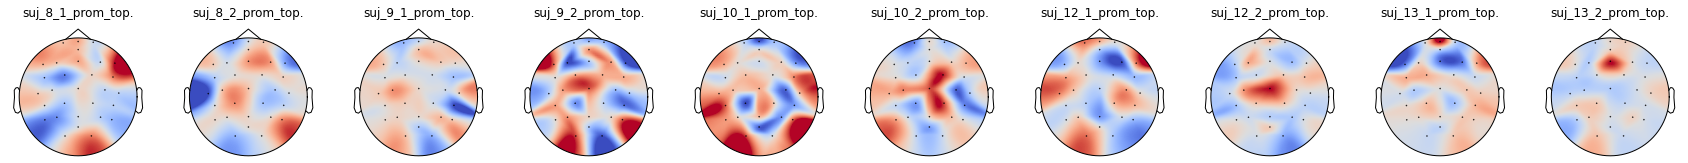

In [12]:
# Promedio de las topografías, por sujeto y por período

# inicio = 1
# fin    = 60
# xticks = np.arange(inicio*srate,(fin+1)*srate,srate)
#fig.suptitle('Series temporales (uV)')
# yticks=[]

# filename = '/suj_8_bl_1.txt'
sujetos = [8,9,10,12,13] # sujetos a graficar: 8,9,10,12,13
periodos = [1,2] #hay solamente dos: 1, 2

cant_graf = len(sujetos)*len(periodos)
# alto_graf = cant_graf*8
fig2, ax2 = plt.subplots(nrows=1, ncols=cant_graf, figsize=(30, 3), gridspec_kw=dict(top=0.9),
                       sharex=True, sharey=True)

k=0 #solamente para iterar por los axes
for i in sujetos:
  for j in periodos:
    filename = 'suj_'+f'{i}'+'_bl_'+f'{j}'+'.txt'
    datos = pd.read_csv(path+filename, sep=',', header=None)
    EEGdata = datos.to_numpy()
    
    EEGdata_meanTopografia = np.mean(EEGdata, axis=1)

    mne.viz.plot_topomap(EEGdata_meanTopografia,
                    info_eeg,
                    cmap='coolwarm', contours=0,
                    axes=ax2[j-1+k],show=False)
    ax2[j-1+k].set_title('suj_'+f'{i}_{j}'+'_prom_top.')  

  k += 2  # porque cada sujeto tiene dos gráficos
    

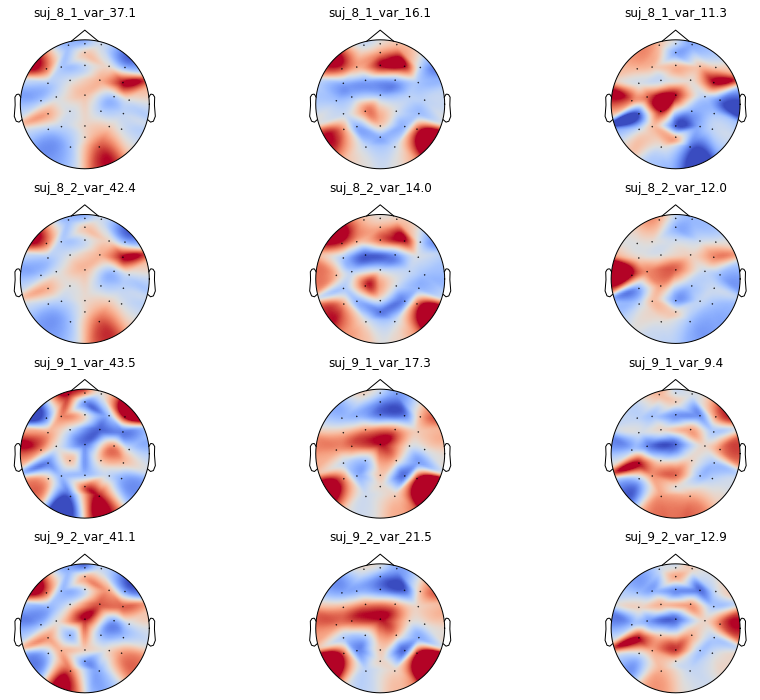

In [13]:
# PCA

# Acá no entendí lo que dice el tp: "para el total de los datos (concatenados en el tiempo)".
# Quizás sea concatenar, para cada sujeto, ambos períodos de reposo (pre y post aprendizaje)
# Pero entonces, si así se concatenan los datos, no entiendo la pregunta "¿qué peso tiene cada proyección en los distintos períodos de reposo"


cant_comp = 3
pca = decomposition.PCA(n_components=cant_comp)

inicio = 1
fin    = 60
xticks = np.arange(inicio*srate,(fin+1)*srate,srate)
#fig.suptitle('Series temporales (uV)')
yticks=[]

# filename = '/suj_8_bl_1.txt'
sujetos = [8,9]#,10,12,13] # sujetos a graficar: 8,9,10,12,13
periodos = [1,2] #hay solamente dos: 1, 2

cant_graf = len(sujetos)*len(periodos)
alto_graf = cant_graf*3
fig3, ax3 = plt.subplots(nrows=cant_graf, ncols=cant_comp, figsize=(15, alto_graf), gridspec_kw=dict(top=0.9),
                       sharex=True, sharey=True)

k=0 #solamente para iterar por los axes
for i in sujetos:
  for j in periodos:
    filename = 'suj_'+f'{i}'+'_bl_'+f'{j}'+'.txt'
    datos = pd.read_csv(path+filename, sep=',', header=None)
    EEGdata = datos.to_numpy()
    
    pca.fit(EEGdata)
    pcs = pca.transform(EEGdata)
    # print(pcs.shape)
    var = pca.explained_variance_ratio_
    # EEGdata_meanTopografia = np.mean(EEGdata, axis=1)

    for p in range(cant_comp):
      mne.viz.plot_topomap(pcs[:,p],
                      info_eeg,
                      cmap='coolwarm', contours=0,
                      axes=ax3[k+j-1,p],show=False)
      ax3[k+j-1,p].set_title('suj_'+f'{i}_{j}_'+'var_'+str(round(var[p]*100,1)))  

  k += 2  # porque cada sujeto tiene dos gráficos
    

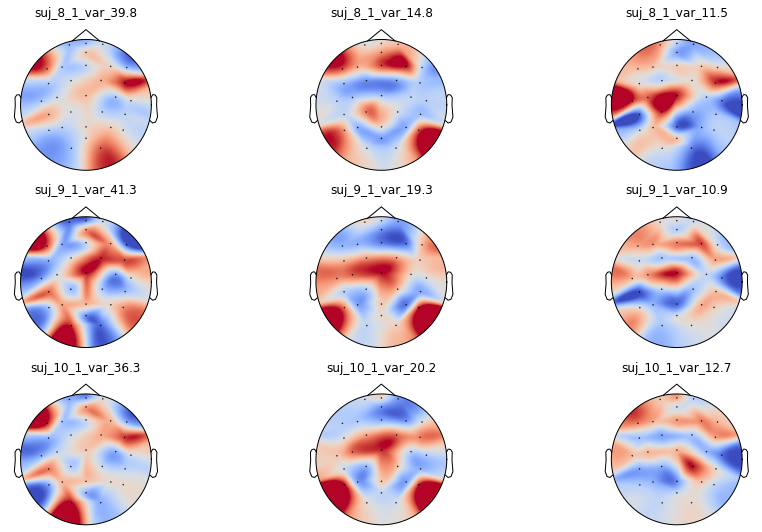

In [14]:
# PCA con datos concatenados a lo largo del tiempo
 
cant_comp = 3
pca = decomposition.PCA(n_components=cant_comp)

# filename = '/suj_8_bl_1.txt'
sujetos = [8,9 ,10]#,12,13] # sujetos a graficar: 8,9,10,12,13
periodos = [1] #hay solamente dos: 1, 2

cant_graf = len(sujetos)*len(periodos)
alto_graf = cant_graf*3
fig3, ax3 = plt.subplots(nrows=cant_graf, ncols=cant_comp, figsize=(15, alto_graf), gridspec_kw=dict(top=0.9),
                       sharex=True, sharey=True)

j = 1
k=0 #solamente para iterar por los axes
for i in sujetos:
  
  filename1 = 'suj_'+f'{i}'+'_bl_'+'1'+'.txt'
  filename2 = 'suj_'+f'{i}'+'_bl_'+'2'+'.txt'
  datos1 = pd.read_csv(path+filename1, sep=',', header=None)
  datos2 = pd.read_csv(path+filename2, sep=',', header=None)

  EEGdata = pd.concat([datos1,datos2], axis = 1).to_numpy()
  
  pca.fit(EEGdata)
  pcs = pca.transform(EEGdata)
  # print(pcs.shape)
  var = pca.explained_variance_ratio_
  # EEGdata_meanTopografia = np.mean(EEGdata, axis=1)

  for p in range(cant_comp):
    mne.viz.plot_topomap(pcs[:,p],
                    info_eeg,
                    cmap='coolwarm', contours=0,
                    axes=ax3[k+j-1,p],show=False)
    ax3[k+j-1,p].set_title('suj_'+f'{i}_{j}_'+'var_'+str(round(var[p]*100,1)))  

  k += 1  # porque cada sujeto ahora tiene un gráfico (concantenado en el tiempo)
    

In [15]:
# Datos referenciados a su promedio (de toda la señal en cada uno de los electrodos)


# filename = '/suj_8_bl_1.txt'
sujetos = [8,9]#,10,12,13] # sujetos a graficar: 8,9,10,12,13
periodos = [1,2] #hay solamente dos: 1, 2

dic_datos_ref = {}

# k=0 #solamente para iterar por los axes
for i in sujetos:
  for j in periodos:
    filename = 'suj_'+f'{i}'+'_bl_'+f'{j}'+'.txt'
    datos = pd.read_csv(path+filename, sep=',', header=None)
    datos_mean = datos.mean(axis = 1)
    datos_std = datos.std(axis = 1)
    datos_ref = datos.sub(datos_mean.squeeze(), axis = 0)#.divide(datos_std, axis = 0 ) # zscore comentado

    key_name = 'suj_'+f'{i}'+'_est_'+f'{j}'
    dic_datos_ref[key_name] = datos_ref
    
    
dic_datos_ref["suj_8_est_1"]

0         1          2     ...      7678      7679      7680
0    6.462766  1.727666  -2.699634  ... -1.452634 -1.583234 -0.029274
1    2.435868 -0.728172  -3.555332  ... -1.732932 -1.502032 -0.368762
2    1.735745 -0.129235  -1.833455  ... -6.379155 -2.697255  2.389645
3    0.834839  3.148589   4.655589  ...  0.447659  4.128989  6.276689
4   -4.078823 -0.783643   3.106977  ...  6.891477  7.964777  5.612577
5    3.638143 -0.938657  -4.859957  ... -8.394057 -7.722857 -0.403037
6    9.028966  4.155766  -1.418834  ... -3.579234 -1.607834  4.794766
7   -0.949598 -1.870898  -1.630898  ...  6.926402  8.150002  7.159502
8   -4.561048 -7.576248 -10.984548  ... -2.444048 -3.118848 -2.841848
9    0.756595 -1.976615  -4.630915  ...  1.522685 -1.004415 -4.106315
10  -0.024299  1.466161   2.073461  ...  4.123261 -0.432149 -6.253339
11 -14.431282 -4.185382   7.999518  ... -2.673182 -5.846882 -8.522882
12  -7.711888 -0.679558   7.061212  ...  5.389012  3.692612  0.794682
13   6.808616 -0.720224  -7.051984  ...  2.483116  4.464416  5.274316
14   6.741022  6.286322   3.932922  ...  6.829422  7.047322  3.750322
15  -2.213300  7.667400  16.867600  ...  7.371700  0.985690 -6.636500
16   3.653558  0.403788  -3.628042  ... -1.217442 -1.686542 -0.995642
17  -0.909674 -1.158274  -1.436174  ... -5.495674 -4.311474 -2.502374
18  -6.793948 -2.314048   2.406352  ... -5.405548 -0.948388  2.117552
19   1.042633 -1.825867  -4.884867  ... -3.266667 -3.262767 -1.263567
20  -1.735384 -3.754184  -6.035584  ...  1.529916 -0.207544 -2.380084
21   5.225578  2.246078  -0.710662  ... -2.755522 -3.551522 -0.229092
22   5.224359  2.685259  -0.418231  ...  4.135059  2.870459 -1.472441
23  -0.216003  2.245447   4.333347  ...  0.613147  4.371047  6.066847
24  -6.252826 -2.332526   1.996574  ... -4.242026 -3.580126 -3.546026
25   5.721281  3.366781   0.659291  ...  0.279451  1.198681  4.416881
26  -2.161183  3.499617   8.109817  ...  5.148817  1.165917 -4.514583
27   0.634369 -2.908911  -6.162411  ... -2.873111 -2.644611 -2.289011
28  -9.800761 -3.164361   4.112339  ...  3.128339  4.851739  4.459339
29   1.895811 -1.852089  -5.373989  ... -4.908189 -5.183289 -4.758189

[30 rows x 7681 columns]

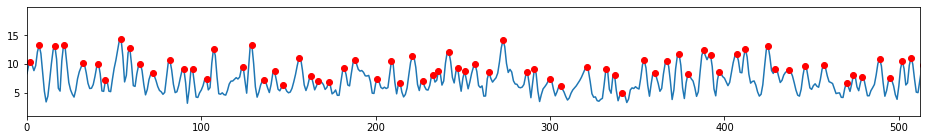

In [42]:
# Calculo GFP

dic_gfp = {}
for key in dic_datos_ref.keys():
    dic_gfp[key] = dic_datos_ref[key].std(ddof=0) #ddof=0 es para que divida por N (divide por N-ddof)
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.std.html




# busco picos de GFP y guardo GFP en las posiciones de los picos

# busco picos de GFP
from scipy.signal import find_peaks 

dic_gfp_posPicos = {}
for key in dic_gfp.keys():
  peaks_pos, peaks_value = find_peaks(dic_gfp[key], prominence=0.8)
  dic_gfp_posPicos[key] = peaks_pos


# Guardo GFP en las posiciones de los picos
dic_gfp_enPicos = {}
for key in dic_gfp_posPicos.keys():
  peaks_pos = dic_gfp_posPicos[key]
  dic_gfp_enPicos[key] = dic_gfp[key][peaks_pos]


# Grafico una parte para ver cómo van quedando los picos
inicio = 0
fin = 4
fig,ax=plt.subplots(ncols=1,figsize=(16,2))
key = 'suj_8_est_1'
ax.plot(dic_gfp[key])
ax.set_xlim([inicio*srate,fin*srate])
# peaks_pos = 
ax.plot(dic_gfp_posPicos[key],dic_gfp_enPicos[key],'ro')


# GFP y picos (esto quedó de antes, pero seguramente sirva)



(30, 4)


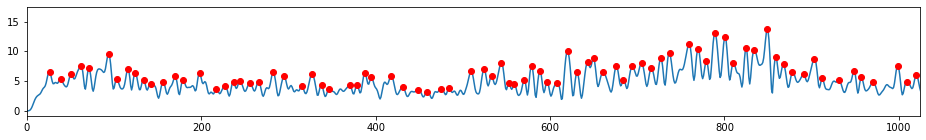

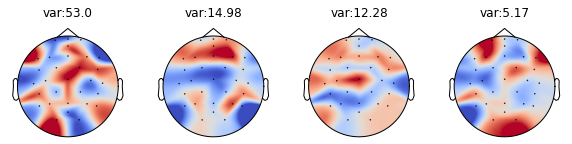

In [ ]:
# calculo GFP
EEGdata_filt.shape
gfp = np.std(EEGdata_filt, axis=0)


# busco picos
from scipy.signal import find_peaks 
# peaks, _ = find_peaks(gfp[inicio:fin*srate], prominence=0.8)
peaks, _ = find_peaks(gfp, prominence=0.8)


# Grafico una parte para ver cómo van quedando los picos
inicio = 0
fin = 4
# fin = int(EEGdata_filt.shape[1]/srate)
fig,ax=plt.subplots(ncols=1,figsize=(16,2))
ax.plot(gfp)
ax.set_xlim([inicio*srate,fin*srate])
ax.plot(peaks,gfp[peaks],'ro')


# guardo la señal de todos los canales solamente en los picos
EEGdata_filt_estados = EEGdata_filt[:,peaks]


#PCA a los estados
pca = decomposition.PCA(n_components=4)
pca.fit(EEGdata_filt_estados)
pcs = pca.transform(EEGdata_filt_estados)
print(pcs.shape)
var = pca.explained_variance_ratio_
fig2, ax = plt.subplots(ncols=pcs.shape[1], figsize=(10, 3), gridspec_kw=dict(top=0.9),
                       sharex=True, sharey=True)
for p in range(pcs.shape[1]):
  mne.viz.plot_topomap(pcs[:,p],
                    info_eeg,
                    cmap='coolwarm', contours=0,
                    axes=ax[p],show=False)
  ax[p].set_title('var:'+str(round(var[p]*100,2)) )      
